In [1]:
import subprocess
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

site = 'ucayali'
proj_dir = Path('/Users/rhchen/JPL/Projects/SERVIR')
aoi_dir = proj_dir / 'AOI' / site
calval_dir = proj_dir / 'CalVal' / site
stacks_dir = proj_dir / 'stacks'

In [2]:
year = 2019
h = 1
v = 1
tile = f'h{h}v{v}'
if year == 2019:
    stack_tif = stacks_dir / f'{site}_stacks_{year}_{tile}_FBD.tif'
else:
    stack_tif = stacks_dir / f'{site}_stacks_{year}_{tile}.tiff'
with rasterio.open(stack_tif) as dset:
    stack = dset.read()
    stack[stack == dset.nodata] = np.nan
    bounds = dset.bounds
    stack_bands = list(dset.descriptions)
    res = dset.res[0]
    crs = dset.crs

In [3]:
# Append disturbance year to stack
coded_tif = calval_dir / 'CODED_date_2000_2020.tif'
if coded_tif.exists():
    # Warp to tile
    coded_tif_utm = calval_dir / f'CODED_date_2000_2020_h{h}v{v}.tif'
    cmd = (f'gdalwarp '
           f'-overwrite -q '
           f'-t_srs epsg:{crs.to_epsg()} '
           f'-te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} '
           f'-tr {res} {res} '
           f'-r near '
           f'-co COMPRESS=LZW '
           f'{coded_tif} {coded_tif_utm}')
    subprocess.check_call(cmd, shell=True)

    # Read in disturbance years
    with rasterio.open(coded_tif_utm) as dset:
        disturb_year = dset.read(1).astype(np.float32)
        disturb_year[disturb_year == dset.nodata] = np.nan

    # Append to stack
    stack = np.concatenate((stack, np.expand_dims(disturb_year, axis=0)))
    stack_bands.append('disturb_year')

In [4]:
# AOI & Tiles
aoi_tiles = aoi_dir / f'{site}_tiles.geojson'
# aoi_boundary = aoi_dir / f'{site}_boundary.geojson'
aoi_boundary = aoi_dir / 'irazola_von_humboldt.geojson'

gdf_tiles = gpd.read_file(aoi_tiles)
gdf_boundary = gpd.read_file(aoi_boundary).to_crs(gdf_tiles.crs).drop([0])    # drop ALEXANDER VON HUMBOLDT
gdf_boundary

,OBJECTID,NOMBDIST,NOMBPROV,geometry
1,4,IRAZOLA,PADRE ABAD,"MULTIPOLYGON (((488076.000 9027268.000, 487075..."


<AxesSubplot:>

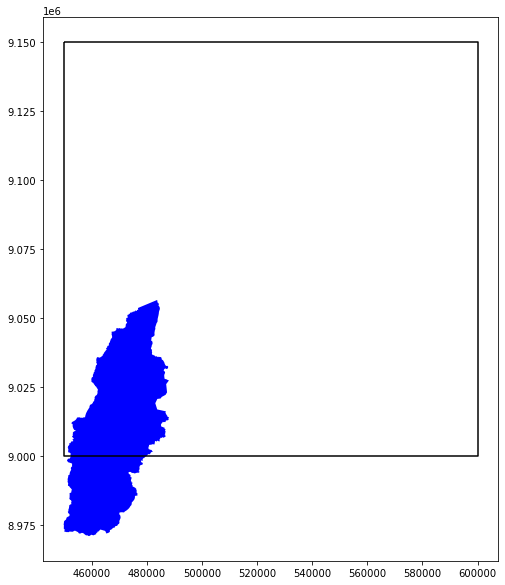

In [5]:
ax = gdf_tiles[(gdf_tiles.h == h) & (gdf_tiles.v == v)].boundary.plot(figsize=(10, 10), color='black')
gdf_boundary.plot(ax=ax, color='blue')

In [6]:
# CalVal GeoJSONs
calval_geojsons = {}
calval_geojsons['oil_palm'] = calval_dir / 'oil_palm' / 'oil_palm_pinto_dec07.geojson'
calval_geojsons['cacao_v1'] = calval_dir / 'cacao' / 'cacao_v1_dec06_MB_OR_NP.geojson'    # v1
calval_geojsons['cacao_v2'] = calval_dir / 'cacao' / 'DB_cacao_MB_OR_130322.geojson'      # v2
calval_geojsons['cacao_v3'] = calval_dir / 'cacao' / 'DB_cacao_coverages.geojson'         # v3
calval_geojsons['forest_pts'] = calval_dir / 'forest' / 'forest_pinto_dec07.geojson'
calval_geojsons['forest_polygons'] = calval_dir / 'forest' / '_VegTypol_Ucayali_v4__Feb2022(1).geojson'

# CalVal GeoDataFrames
calval_gdf = {}
for land_cover, geojson in calval_geojsons.items():
    calval_gdf[land_cover] = gpd.read_file(geojson).to_crs(gdf_tiles.crs)

In [7]:
# Organize LAND_COVER names for cacao gdfs
print('BEFORE:')
print(calval_gdf['cacao_v1'].LAND_COVER.unique())
print(calval_gdf['cacao_v2'].LAND_COVER.unique())
print(calval_gdf['cacao_v3'].LAND_COVER.unique())

cacao_mono_names = ['clean_cocoa', 'Cacao Puro', 'Clean cocoa', 'cacao_mono']
cacao_agro_names = ['cocoa_with_trees', 'Cacao con arboles', 'Cocoa with trees', 'cacao_agro']

for iv in range(3):
    for ir in calval_gdf[f'cacao_v{iv+1}'].index:
        if calval_gdf[f'cacao_v{iv+1}'].loc[ir, 'LAND_COVER'] in cacao_mono_names:
            calval_gdf[f'cacao_v{iv+1}'].loc[ir, 'LAND_COVER'] = 'cacao_mono'
        elif calval_gdf[f'cacao_v{iv+1}'].loc[ir, 'LAND_COVER'] in cacao_agro_names:
            calval_gdf[f'cacao_v{iv+1}'].loc[ir, 'LAND_COVER'] = 'cacao_agro'
        else:
            print('Not recognized LAND_COVER name for cacao!')

print('AFTER:')
print(calval_gdf['cacao_v1'].LAND_COVER.unique())
print(calval_gdf['cacao_v2'].LAND_COVER.unique())
print(calval_gdf['cacao_v3'].LAND_COVER.unique())

# Concatenate cacao gdfs
calval_gdf['cacao'] = gpd.GeoDataFrame(pd.concat([calval_gdf['cacao_v1'], calval_gdf['cacao_v2'], calval_gdf['cacao_v3']], ignore_index=True), crs=gdf_tiles.crs)

# Separate mono- and agro-cacao
calval_gdf['cacao_mono'] = calval_gdf['cacao'][calval_gdf['cacao'].LAND_COVER == 'cacao_mono']
calval_gdf['cacao_agro'] = calval_gdf['cacao'][calval_gdf['cacao'].LAND_COVER == 'cacao_agro']

BEFORE:
['clean_cocoa' 'cocoa_with_trees']
['Cacao con arboles' 'Cacao Puro' 'Clean cocoa' 'Cocoa with trees']
['Clean cocoa' 'Cocoa with trees']
AFTER:
['cacao_mono' 'cacao_agro']
['cacao_agro' 'cacao_mono']
['cacao_mono' 'cacao_agro']


In [8]:
# Seprarate different COBERTURA (coverage)
for c in calval_gdf['forest_polygons'].COBERTURA.unique():
    calval_gdf[c] = calval_gdf['forest_polygons'][calval_gdf['forest_polygons'].COBERTURA == c]

<AxesSubplot:>

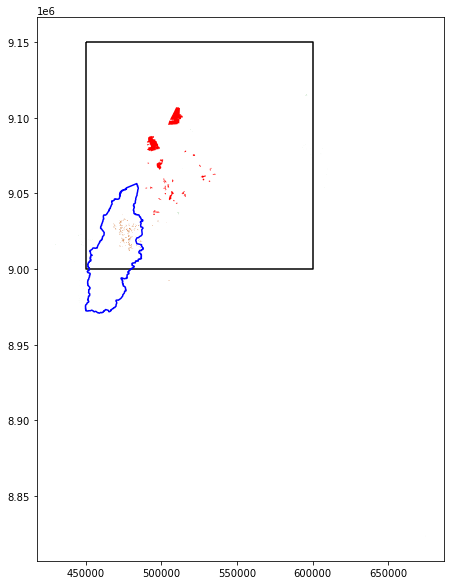

In [9]:
ax = gdf_tiles[(gdf_tiles['h'] == h) & (gdf_tiles['v'] == v)].boundary.plot(figsize=(10, 10), color='black')
gdf_boundary.boundary.plot(ax=ax, color='blue')
calval_gdf['oil_palm'].plot(ax=ax, color='red')
calval_gdf['cacao'].plot(ax=ax, color='chocolate')
calval_gdf['Purma'].plot(ax=ax, color='green')

<AxesSubplot:>

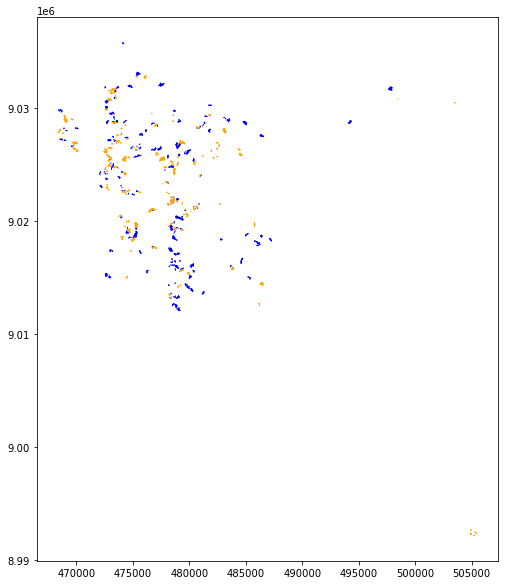

In [10]:
ax = calval_gdf['cacao_mono'].plot(figsize=(10, 10), color='blue')
calval_gdf['cacao_agro'].plot(ax=ax, color='orange')

In [11]:
# Drop unnecessary gdfs
print('BEFORE:', calval_gdf.keys())
calval_gdf.pop('cacao')
calval_gdf.pop('cacao_v1')
calval_gdf.pop('cacao_v2')
calval_gdf.pop('cacao_v3')
calval_gdf.pop('forest_polygons')
print('AFTER:', calval_gdf.keys())

BEFORE: dict_keys(['oil_palm', 'cacao_v1', 'cacao_v2', 'cacao_v3', 'forest_pts', 'forest_polygons', 'cacao', 'cacao_mono', 'cacao_agro', 'Purma', 'Bosque_secundario_o_degradado', 'Pastizales_o_herbazales_degradados', 'Bosque_de_colina_baja', 'Bosque_de_colina_alta', 'Aguajales', 'Bosque_secudario_o_degradado', 'Bosque_inundado'])
AFTER: dict_keys(['oil_palm', 'forest_pts', 'cacao_mono', 'cacao_agro', 'Purma', 'Bosque_secundario_o_degradado', 'Pastizales_o_herbazales_degradados', 'Bosque_de_colina_baja', 'Bosque_de_colina_alta', 'Aguajales', 'Bosque_secudario_o_degradado', 'Bosque_inundado'])


In [12]:
# Extracting values of stack bands for the polygons
tmp_dir = calval_dir / 'tmp'
if not tmp_dir.exists():
    tmp_dir.mkdir()
calval_df = {}
columns = ['id'] + stack_bands
df_all = pd.DataFrame(columns=columns)
for lc_id, (land_cover, gdf) in enumerate(calval_gdf.items()):        
    # Save polygon in UTM proj. to GeoJSON
    geojson_utm = tmp_dir / f'{site}_{land_cover}_utm.geojson'
    with warnings.catch_warnings():
        # Ignore the FutureWarning, which will be fixed in the next release of geopandas
        warnings.simplefilter("ignore")
        gdf.to_file(geojson_utm, driver='GeoJSON')
    
    # Rasterize polygon
    tif_utm = geojson_utm.with_suffix('.tif')
    cmd = (f'gdal_rasterize -q -burn {lc_id} -a_nodata -9999 -ot Int16 -tr 30 30 -tap -co compress=lzw {geojson_utm} {tif_utm}')
    subprocess.check_call(cmd, shell=True)
    
    # Warp to tile
    tif_tile = tif_utm.with_stem(tif_utm.stem.replace('_utm', f'_h{h}v{v}'))
    cmd = (f'gdalwarp '
           f'-overwrite -q '
           f'-te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} '
           f'-tr {res} {res} '
           f'-r near '
           f'-co COMPRESS=LZW '
           f'{tif_utm} {tif_tile}')
    subprocess.check_call(cmd, shell=True)
    
    # Get pixels of land cover
    with rasterio.open(tif_tile) as dset:
        pixel_id = dset.read(1)
        mask = dset.read_masks(1)
    rows, cols = np.where(mask == 255)
    # rows, cols = np.where(pixel_id == lc_id)
    pixel_id = pixel_id[rows, cols]

    print(f'id {lc_id}: {land_cover} - {pixel_id.shape[0]} pixels in {tile} tile')
    
    # Create DataFrame
    lc_and_stack = np.full((pixel_id.shape[0], len(columns)), np.nan)
    lc_and_stack[:, 0] = pixel_id
    lc_and_stack[:, 1:] = stack[:, rows, cols].transpose()
    # print(id_and_data)
    calval_df[land_cover] = pd.DataFrame(lc_and_stack, columns=columns)
    df_all = pd.concat([df_all, calval_df[land_cover]], ignore_index=True)

df_all.to_csv(calval_dir / f'{site}_lc_and_stack.csv', index=False)

id 0: oil_palm - 173944 pixels in h1v1 tile
id 1: forest_pts - 34 pixels in h1v1 tile
id 2: cacao_mono - 5235 pixels in h1v1 tile
id 3: cacao_agro - 4558 pixels in h1v1 tile
id 4: Purma - 733 pixels in h1v1 tile
id 5: Bosque_secundario_o_degradado - 23427 pixels in h1v1 tile
id 6: Pastizales_o_herbazales_degradados - 785 pixels in h1v1 tile
id 7: Bosque_de_colina_baja - 11064 pixels in h1v1 tile
id 8: Bosque_de_colina_alta - 0 pixels in h1v1 tile
id 9: Aguajales - 5061 pixels in h1v1 tile
id 10: Bosque_secudario_o_degradado - 4716 pixels in h1v1 tile
id 11: Bosque_inundado - 0 pixels in h1v1 tile


In [13]:
# land_covers = ['oil_palm', 'cacao_mono', 'cacao_agro', 'forest_pts', 'forest_polygons']
# labels = ['Oil Palm', 'Cacao (mono)', 'Cacao (agro)', 'Forest (pts)', 'Forest (poly)']

land_covers = ['oil_palm', 'cacao_mono', 'cacao_agro', 'forest_pts', 'Purma']
labels = ['Oil Palm', 'Cacao (mono)', 'Cacao (agro)', 'Forest (pts)', 'Purma']

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [30, 20]

dict_bins = {
    'C-VV': np.arange(0, 0.5+0.01, 0.01),
    'C-VH': np.arange(0, 0.1+0.002, 0.002),
    'C-RVI': np.arange(0, 1.2+0.01, 0.01),
    'L-HH': np.arange(0, 0.5+0.01, 0.01),
    'L-HV': np.arange(0, 0.1+0.002, 0.002),
    'L-RVI': np.arange(0, 2+0.01, 0.01),
    'NDVI': np.arange(0.2, 1+0.1, 0.1),
}

# Boxplots

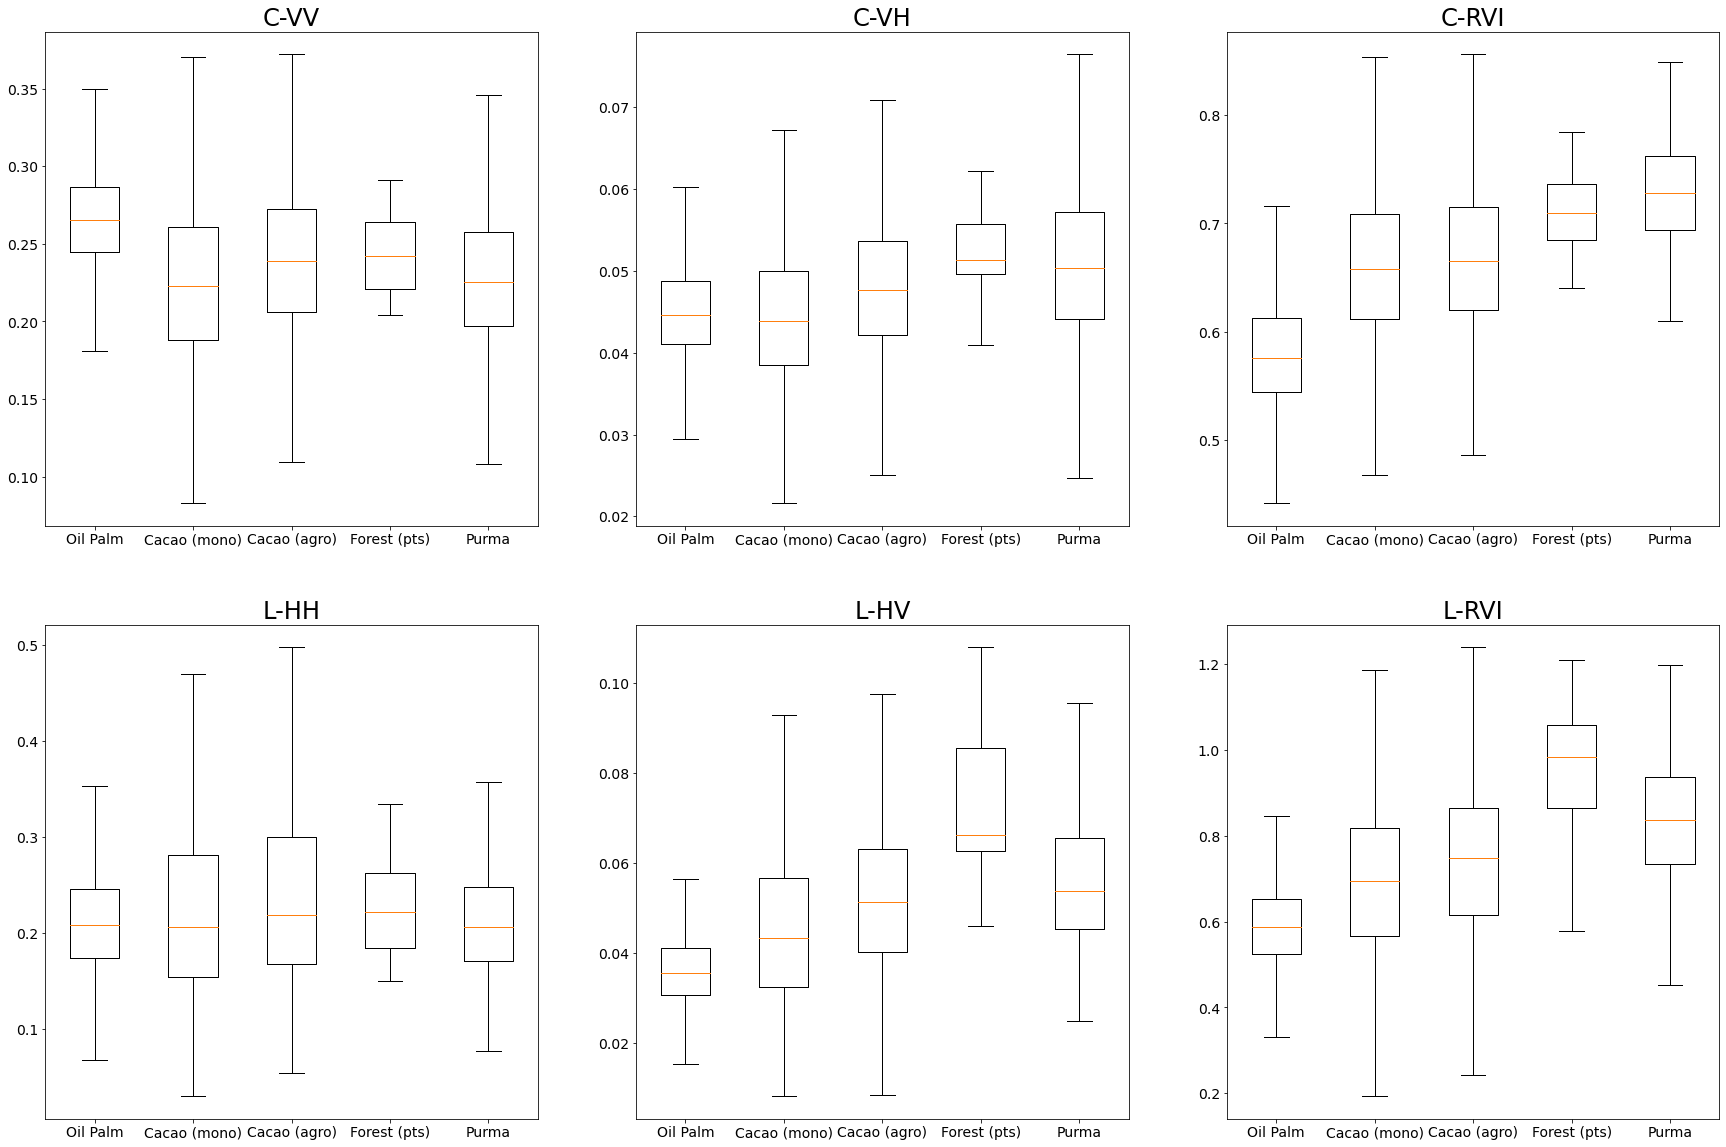

In [14]:
# Boxplots
ax = []
for i, data in enumerate(['C-VV', 'C-VH', 'C-RVI', 'L-HH', 'L-HV', 'L-RVI']):
    ds_list = []
    for land_cover in land_covers:
        if 'C-RVI' not in calval_df[land_cover].columns:
            calval_df[land_cover]['C-RVI'] = 4*calval_df[land_cover]['C-VH'] / (calval_df[land_cover]['C-VV'] + calval_df[land_cover]['C-VH'])
        if 'L-RVI' not in calval_df[land_cover].columns:
            calval_df[land_cover]['L-RVI'] = 4*calval_df[land_cover]['L-HV'] / (calval_df[land_cover]['L-HH'] + calval_df[land_cover]['L-HV'])
        ds_list.append(calval_df[land_cover][data].dropna())
        
    ax.append(plt.subplot(2, 3, i+1))
    ax[i].boxplot(ds_list, labels=labels, showfliers=False)
    ax[i].set_title(data, fontsize='xx-large')
    # ax[i].set_ylim((dict_bins[data][0], dict_bins[data][-1]))

# Boxplots (cacao_mono filtered with disturbance year)

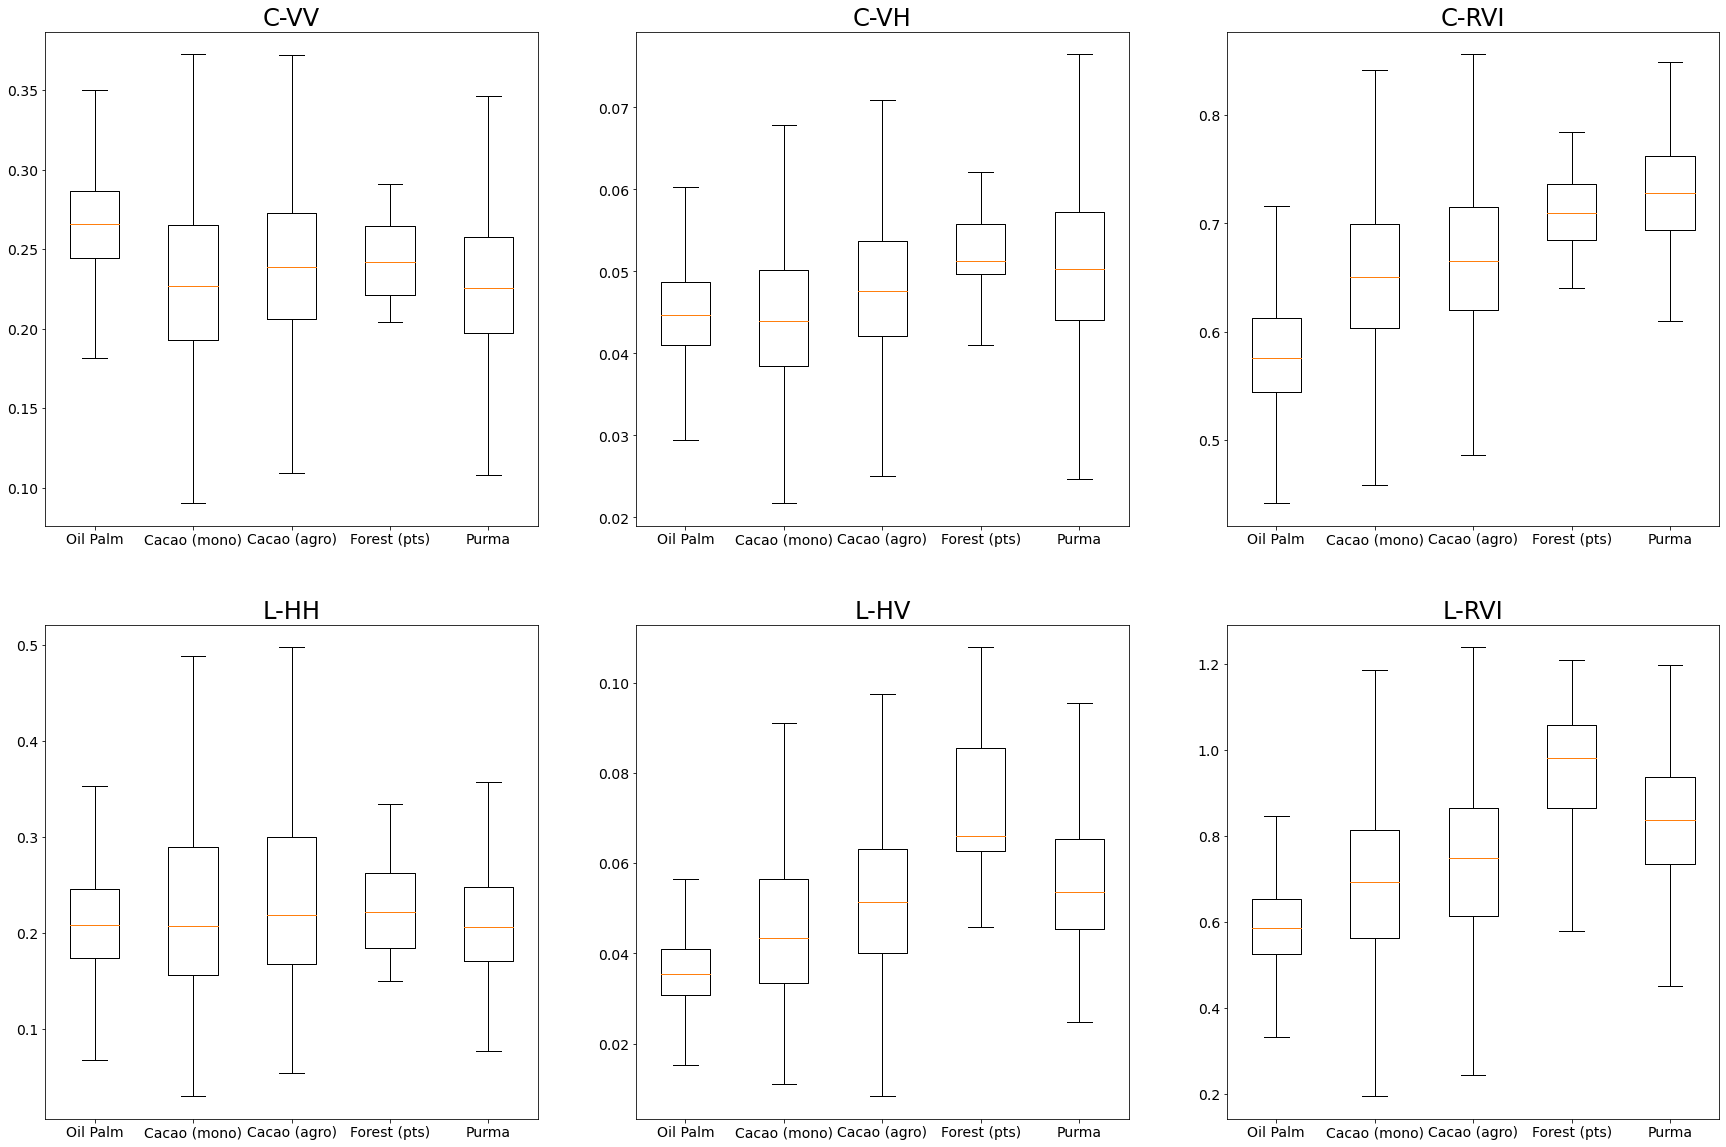

In [15]:
disturbance_year_thres = 2006

ax = []
for i, data in enumerate(['C-VV', 'C-VH', 'C-RVI', 'L-HH', 'L-HV', 'L-RVI']):
    ds_list = []
    for land_cover in land_covers:
        if 'C-RVI' not in calval_df[land_cover].columns:
            calval_df[land_cover]['C-RVI'] = 4*calval_df[land_cover]['C-VH'] / (calval_df[land_cover]['C-VV'] + calval_df[land_cover]['C-VH'])
        if 'L-RVI' not in calval_df[land_cover].columns:
            calval_df[land_cover]['L-RVI'] = 4*calval_df[land_cover]['L-HV'] / (calval_df[land_cover]['L-HH'] + calval_df[land_cover]['L-HV'])
        
        if land_cover == 'cacao_mono':
            ds_list.append(calval_df[land_cover][calval_df[land_cover]['disturb_year'] > disturbance_year_thres][data])
        else:
            ds_list.append(calval_df[land_cover][data].dropna())
        
    ax.append(plt.subplot(2, 3, i+1))
    ax[i].boxplot(ds_list, labels=labels, showfliers=False)
    ax[i].set_title(data, fontsize='xx-large')
    # ax[i].set_ylim((dict_bins[data][0], dict_bins[data][-1]))

In [16]:
land_cover = 'cacao_mono'
print(f'{land_cover} - without disturbance year filter')
for data in ['C-VH', 'L-HV']:
    print(data)
    print(f"Q1: {calval_df[land_cover][data].quantile(q=0.25):.6f}")
    print(f"median: {calval_df[land_cover][data].quantile(q=0.5):.6f}")
    print(f"Q3: {calval_df[land_cover][data].quantile(q=0.75):.6f}")

cacao_mono - without disturbance year filter
C-VH
Q1: 0.038486
median: 0.043826
Q3: 0.050013
L-HV
Q1: 0.032436
median: 0.043149
Q3: 0.056639


In [17]:
land_cover = 'cacao_mono'
print(f'{land_cover} - filtered with disturbance year {disturbance_year_thres}')
for data in ['C-VH', 'L-HV']:
    print(data)
    print(f"Q1: {calval_df[land_cover][calval_df[land_cover]['disturb_year'] > disturbance_year_thres][data].quantile(q=0.25):.6f}")
    print(f"median: {calval_df[land_cover][calval_df[land_cover]['disturb_year'] > disturbance_year_thres][data].quantile(q=0.5):.6f}")
    print(f"Q3: {calval_df[land_cover][calval_df[land_cover]['disturb_year'] > disturbance_year_thres][data].quantile(q=0.75):.6f}")

cacao_mono - filtered with disturbance year 2006
C-VH
Q1: 0.038419
median: 0.043977
Q3: 0.050197
L-HV
Q1: 0.033380
median: 0.043545
Q3: 0.056521


In [18]:
# Separability (Kaufman and Remer 1994)
# m > 1: good separation
# m < 1: poor separation
feature = 'C-RVI'
m = np.zeros((len(land_covers), len(land_covers)))
for i, lc1 in enumerate(land_covers):
    for j, lc2 in enumerate(land_covers):
        if lc1 == lc2:
            continue
        u1 = calval_df[lc1][feature].mean()
        s1 = calval_df[lc1][feature].std()
        u2 = calval_df[lc2][feature].mean()
        s2 = calval_df[lc2][feature].std()
        m[i, j] = np.abs(u1 - u2) / (s1 + s2)
m

array([[0.        , 0.63800803, 0.71055887, 1.37644135, 1.37392681],
       [0.63800803, 0.        , 0.04074064, 0.39023854, 0.48537082],
       [0.71055887, 0.04074064, 0.        , 0.35285227, 0.45554642],
       [1.37644135, 0.39023854, 0.35285227, 0.        , 0.18829437],
       [1.37392681, 0.48537082, 0.45554642, 0.18829437, 0.        ]])